Where I build up intuition for RNNs and attempt to solve the exercises in [section 9.5 of the d2l book](https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html) from scratch in pytorch (without using the d2l library).

First, a little context and intermediate implementations that helped me understand the one the book and Pytorch follow. For better explainers see [[1]](https://explained.ai/rnn/),[[2]](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb),[[3]](https://gist.github.com/karpathy/d4dee566867f8291f086).

# Context

RNNs are layers that maintain a state $\mathbf{H}_t$ and update it every time you a forward pass. The new value at "time" $t$ depends on the current input $\mathbf{X}_t$ and the previous value  $\mathbf{H}_{t-1}$ according to

$$
\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}  + \mathbf{b}_\textrm{h})
$$

After updating its state, the layer can then produce an output.

$$
\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{\textrm{hq}} + \mathbf{b}_\textrm{q}
$$

What about the dimensions? There are two choices we get to make. The first is the dimension $d$ of the vectors we represent our words/characters/tokens with that will dictate the shape of our input $\mathbf{X}_t \in \mathbb{R}^{n \times d}$, where $n$ is the batch size. The second is the hidden dimension $h$ we wish to transform our tokens to, which will dictate the shape of the hidden state as $\mathbf{H}_t \in \mathbb{R}^{n \times h}$. 

We can visualize the layer by displaying how it behaves across forward passes $t-1$, $t$, $t+1$ by "unrolling time" horizontally.

![Fig. 9.4.1 From the book.](images/RNN_diagram.svg)

In [1]:
#| echo: false
#| code-summary: Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from d2l import torch as d2l

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, itertools, time, random, requests, re

device = 'cpu'

We first sort out the data we will feed the RNN, mainly following sections [9.2]() and [9.3]() implemented from scratch.

In [2]:
#| code-summary: Get and preprocess data

# url = 'http://d2l-data.s3-accelerate.amazonaws.com/' + 'timemachine.txt'
# with open('data/timemachine.txt', 'w') as f:
#     f.write(requests.get(url).text)

with open('data/timemachine.txt', 'r') as f:
    text = f.read()

text = re.sub('[^A-Za-z]+', ' ', text).lower() # ignore punctuation: 'the time machine by h g wells i the time traveller ...'
tokens = list(text) # character-level tokens: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ...]
vocab = set(tokens) # unique characters: {' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', ...}
char_to_ix = {c:i for i, c in enumerate(vocab)} # character to index: {' ': 0, 'a': 1, 'b': 2, 'c': 3, ...}
ix_to_char = {i:c for i, c in enumerate(vocab)} # index to character: {0: ' ', 1: 'a', 2: 'b', 3: 'c', ...}


# Just so we can use torch's DataLoaders
class OffsetSequences(Dataset):
    
    def __init__(self, tokens, seq_len): self.tokens = tokens; self.seq_len = seq_len
    def __len__(self): return len(self.tokens) - self.seq_len

    def __getitem__(self, idx):
        if idx >= len(self): raise IndexError
        t = lambda l: torch.Tensor(l).long()
        return t(self.tokens[idx:idx + self.seq_len]), t(self.tokens[idx + 1:idx + 1 + self.seq_len])

# Hyperparams
def get_data(batch_size, num_steps, train_prop = 0.7):
    train_cutoff = int(train_prop * len(tokens))
    train_dataset = OffsetSequences([char_to_ix[t] for t in tokens[:train_cutoff]], num_steps)
    test_dataset  = OffsetSequences([char_to_ix[t] for t in tokens[train_cutoff:]], num_steps)
    train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
    test_loader   = DataLoader(test_dataset,  batch_size = batch_size, shuffle = False, drop_last = True)
    return train_dataset, test_dataset, train_loader, test_loader

batch_size, num_steps = 1024, 16
train_dataset, test_dataset, train_loader, test_loader = get_data(batch_size, num_steps)
train_dataset_demo, test_dataset_demo, train_loader_demo, test_loader_demo = get_data(2, 3)

We can now obtain sequences of our text data offset by one to feed as input and targets. Let's display the first few tokenized characters of the text and the first (input, target) pair when we set the sequence length `num_steps` to 3:

In [1100]:
#| code-fold: false
X, Y = train_dataset_demo[0]
[char_to_ix[i] for i in tokens[:5]], X, Y

([13, 12, 8, 25, 13], tensor([13, 12,  8]), tensor([12,  8, 25]))

And can use data loaders to chunk several such pairs. For example, if we set the `batch_size=2`:

In [1101]:
#| code-fold: false
X, Y = next(iter(DataLoader(train_dataset_demo, batch_size = 2, shuffle = False)))
print(f'X: {X}\nY: {Y}\n\nBoth shaped as: {X.shape}')

X: tensor([[13, 12,  8],
        [12,  8, 25]])
Y: tensor([[12,  8, 25],
        [ 8, 25, 13]])

Both shaped as: torch.Size([2, 3])


In practice, we'll have much larger sequence lengths, and batch sizes and will set `shuffle=True` to grab random sequences from the corpus. Finally, we need to one-hot encode the tokens ([Sec. 9.5.2.1](https://d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html#one-hot-encoding)) and end up with the shape (sequence length, batch size, vocab size):

In [1102]:
#| code-fold: false
X = F.one_hot(X.T, len(vocab)).type(torch.float32)
X.shape # seq_length, batch_size, vocab_size

torch.Size([3, 2, 27])

Since we are now ready to start feeding in data let's start with a literal implementation of the above description of the RNN layer:

In [1103]:
#| code-summary: A literal implementation
#| code-fold: show
class RNNScratch(nn.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, num_outputs, sigma = 0.01):
        super().__init__()
        self.num_inputs = num_inputs; self.num_hiddens = num_hiddens; self.num_outputs = num_outputs

        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

        self.W_hq = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b_q = nn.Parameter(torch.zeros(num_outputs))
    
    def forward(self, X, H = None):
        # X: (batch_size, vocab_size)
        if H is None: H = torch.zeros(X.shape[0], self.num_hiddens)
        H = torch.tanh(torch.matmul(X, self.W_xh) + torch.matmul(H, self.W_hh) + self.b_h)
        O = torch.matmul(H, self.W_hq) + self.b_q
        return O, H

Remember we feed RNNs tokens sequentially. Let's first feed in the first tokens and inspect the output shapes.

In [1104]:
#| code-fold: false
m = RNNScratch(num_inputs = len(vocab), num_hiddens = 64, num_outputs = len(vocab))
output, hidden_state = m(X[0])
X[0].shape, output.shape, hidden_state.shape

(torch.Size([2, 27]), torch.Size([2, 27]), torch.Size([2, 64]))

Which makes sense since the layer must output, for each example in the batch, (the logits for) which of the 27 characters is more likely to follow the input. We also have the layer output the updated hidden state `H` to pass in the next forward pass(es):

In [1105]:
#| code-fold: false
output, hidden_state = m(X[1], hidden_state)
output, hidden_state = m(X[2], hidden_state)

Since we've now reached the end of the sequence we can compare the predicted and actual last word to compute a loss:

In [1106]:
#| code-fold: false
F.cross_entropy(output, Y.T[-1])

tensor(3.2961, grad_fn=<NllLossBackward0>)

With this simple setup, we can already train a simple language model:

Text(0.5, 1.0, 'Final perplexity: 12.89')

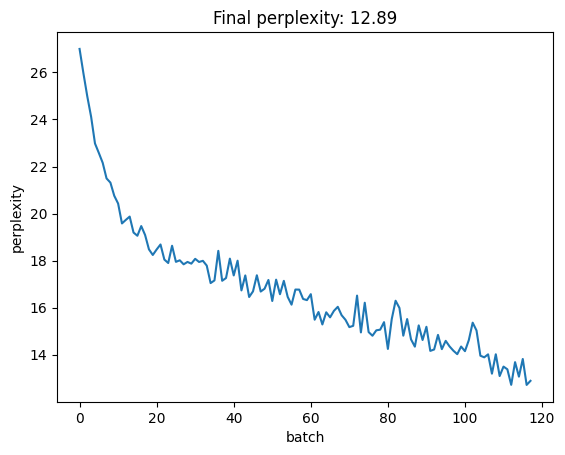

In [1108]:
#| code-summary: Train small lm

# train on train_loader, not train_loader_demo
m = RNNScratch(num_inputs = len(vocab), num_hiddens = 32, num_outputs = len(vocab))
opt = optim.SGD(m.parameters(), lr = 1)
losses = []

for X, Y in train_loader:

    X = F.one_hot(X.T, len(vocab)).type(torch.float32)

    opt.zero_grad()

    hidden_state = None
    for i in range(num_steps):
        output, hidden_state = m(X[i], hidden_state)

    loss = F.cross_entropy(output, Y.T[-1])
    loss.backward()
    opt.step()
    
    losses.append(np.exp(loss.item()))

plt.plot(losses); plt.ylabel('perplexity'); plt.xlabel('batch'); plt.title(f'Final perplexity: {losses[-1]:.2f}')

Now instead of only teaching the network to predict the last character of the sequence using all the previous ones $(x_t | x_{t-1}, ~\dots~x_1)$ we could ["increase de signal"](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb) in our loss by evaluating all intermediate predictions $(x_2 | x_1)$, $(x_3|x_2, x_1)$, ..., $(x_t | x_{t-1}, ~\dots~x_1)$. We can do so by accumulating the intermediate logits in a list, stacking them, and then making sure our shapes make sense before passing to `cross_entropy`. Here we assume all intermediate predictions are equally weighted in the loss, but you could play around with this. 

Text(0.5, 1.0, 'Final perplexity: 17.08')

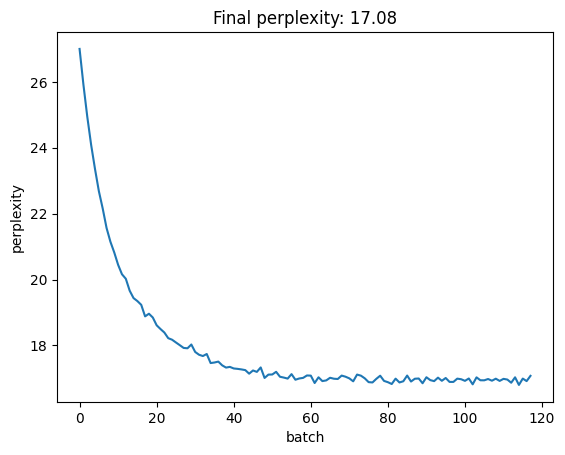

In [1109]:
#| code-summary: Train with intermediate predictions

# train on train_loader, not train_loader_demo
m = RNNScratch(num_inputs = len(vocab), num_hiddens = 32, num_outputs = len(vocab))
opt = optim.SGD(m.parameters(), lr = 1)
losses = []

for X, Y in train_loader:

    X = F.one_hot(X.T, len(vocab)).type(torch.float32)

    opt.zero_grad()

    outputs = [] # accumulate intermediate predictions
    hidden_state = None
    for i in range(num_steps):
        output, hidden_state = m(X[i], hidden_state)
        outputs.append(output)

    outputs = torch.stack(outputs) # (seq_len, batch_size, vocab_size)
    outputs = outputs.view(-1, len(vocab)) # (seq_len * batch_size, vocab_size)
    targets = Y.view(-1) # (batch_size, seq_len) -> (seq_len * batch_size)

    loss = F.cross_entropy(outputs, targets)
    loss.backward()
    opt.step()
    
    losses.append(np.exp(loss.item()))

plt.plot(losses); plt.ylabel('perplexity'); plt.xlabel('batch'); plt.title(f'Final perplexity: {losses[-1]:.2f}')

Why do we get a higher loss? Well, asking the RNN to make correct intermediate predictions is a harder task than just predicting the last character. Thus we probably require more training, capacity, and tuning. 

Anyway, our training loop is getting pretty messy. To match the book's implementation and tidy up our loop we can first let the RNN loop though the sequence itself:

In [1110]:
#| code-fold: show
class RNNScratch(nn.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, num_outputs, sigma = 0.01):
        super().__init__()
        self.num_inputs = num_inputs; self.num_hiddens = num_hiddens; self.num_outputs = num_outputs

        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

        self.W_hq = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b_q = nn.Parameter(torch.zeros(num_outputs))
    
    def forward(self, X, H = None):
        # Expects X: (seq_length, batch_size, num_inputs i.e. vocab_size)
        # Outputs X: (seq_len, batch_size, num_outputs i.e. vocab_size)
        if H is None: H = torch.zeros(X.shape[1], self.num_hiddens) # (batch_size, num_hiddens)
        outputs = []
        for X_i in X: # loop over first dim
            H = torch.tanh(torch.matmul(X_i, self.W_xh) + torch.matmul(H, self.W_hh) + self.b_h)
            O = torch.matmul(H, self.W_hq) + self.b_q
            outputs.append(O)
        return torch.stack(outputs), H

And make sure the output shapes still make sense:

In [1111]:
#| code-fold: show
m = RNNScratch(num_inputs = len(vocab), num_hiddens = 32, num_outputs = len(vocab))
X, Y = next(iter(train_loader_demo))
X = F.one_hot(X.T, len(vocab)).type(torch.float32)
outputs, H = m(X)
outputs.shape, H.shape

(torch.Size([3, 2, 27]), torch.Size([2, 32]))

Finally, the book and Pytorch don't include the output linear layer in the RNN layer. This way we can have the RNN layer focus only on updating the hidden state and could use it to generate output using a linear layer or something more complicated like a whole decoder module.

In [1112]:
#| code-summary: RNN layer without output layer
class RNNScratch(nn.Module):
    """The RNN model implemented from scratch."""
    def __init__(self, num_inputs, num_hiddens, sigma = 0.01):
        super().__init__()
        self.num_inputs = num_inputs; self.num_hiddens = num_hiddens

        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))
    
    def forward(self, X, H = None):
        # Expects X: (seq_length, batch_size, num_inputs i.e. vocab_size)
        # Outputs: (seq_len, batch_size, num_outputs i.e. vocab_size)
        if H is None: H = torch.zeros(X.shape[1], self.num_hiddens)
        hidden_states = [] # we now return all hidden states
        for X_i in X:
            H = torch.tanh(torch.matmul(X_i, self.W_xh) + torch.matmul(H, self.W_hh) + self.b_h)
            hidden_states.append(H)
        return torch.stack(hidden_states)

We can now define a language model module to deal with generating the output, embedding the input, and sampling sequences from the model. 

In [1113]:
#| code-summary: RNN Language Model
#| code-fold: show

class RNNLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens, sigma = 0.01):
        super().__init__()
        self.vocab_size = vocab_size

        self.rnn = RNNScratch(vocab_size, num_hiddens, sigma)
        self.W_hq = nn.Parameter(torch.randn(num_hiddens, vocab_size) * sigma)
        self.b_q = nn.Parameter(torch.zeros(vocab_size))

    def embed(self, X): return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, hidden_states):
        return torch.stack([torch.matmul(H, self.W_hq) + self.b_q for H in hidden_states])
    
    def forward(self, X, H = None):
        hidden_states = self.rnn(self.embed(X), H)
        return self.output_layer(hidden_states)
    
    @torch.no_grad()
    def generate(self, preamble, num_chars, char_to_ix):
    
        generation = preamble
        prepare_X = lambda char: self.embed(torch.Tensor([[char_to_ix[char]]]).long())
        hidden_state = None

        for char in preamble: # warm-up
            hidden_state = self.rnn(prepare_X(char), hidden_state)[-1] # only the last hidden state

        for _ in range(num_chars): # generation
            hidden_state = self.rnn(prepare_X(generation[-1]), hidden_state)[-1]
            output = self.output_layer([hidden_state])
            generation += ix_to_char[output.argmax(dim = 2).item()]

        return generation

Let's test it out. We first sample a sequence continuation before training the model.

In [1129]:
#| code-fold: false
m = RNNLM(vocab_size = len(vocab), num_hiddens = 32)
m.generate('it has', 20, char_to_ix)

'it hasxhkzwytyqdmuvngggggg'

And train the model, now with the simplified training loop. To imitate Section 9.5.4. of the book, we do not use intermediate predictions and clip the gradients to magnitude 1 using `nn.utils.clip_grad_norm_`.

In [1130]:
#| code-summary: Evaluation function
@torch.no_grad()
def eval(m, test_loader):
    m.eval()
    loss = 0
    for X, Y in test_loader:
        outputs = m(X)
        outputs = outputs[-1]
        targets = Y[:, -1]
        loss += F.cross_entropy(outputs, targets).item()
    return np.exp(loss / len(test_loader)) # perplexity

Text(0, 0.5, 'perplexity')

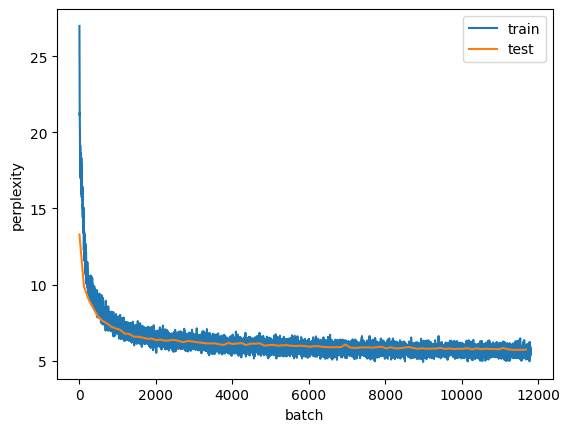

In [1131]:
#| code-summary: Train the model
opt = optim.SGD(m.parameters(), lr = 1)
train_perplexities, test_perplexities = [], []
for _ in range(100):

    for X, Y in train_loader:

        opt.zero_grad()

        outputs = m(X)
        outputs = outputs[-1]
        targets = Y[:, -1]

        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(m.parameters(), 1) # Clip the gradient
        opt.step()
        
        train_perplexities.append(np.exp(loss.item()))
    test_perplexities.append(eval(m, test_loader))

plt.plot(train_perplexities, label = 'train')
plt.plot(list(range(0, len(train_perplexities), len(train_loader))),test_perplexities, label = 'test')
plt.legend(); plt.xlabel('batch'); plt.ylabel('perplexity')

Finally, let's see what the trained model generates:

In [1133]:
#| code-fold: false
m.generate('it has', 20, char_to_ix)

'it hase the stound the sto'

I think that is enough context. Let's get to some of the exercises I found interesting.

# 1
>Does the implemented language model predict the next token based on all the past tokens up to the very first token in The Time Machine?

In general no. The model is trained to predict the next token based only on the previous `num_steps` tokens. However, after generation, you could pass in the whole of The Time Machine to the model in the warm-up phase and then ask it to predict the next token. In principle the prediction would be based on all tokens up to the very first token but since the model has to compress every token it has seen into the hidden state it's likely to not remember much of the beginning of the text.

# 2
>Which hyperparameter controls the length of history used for prediction?

`num_steps` during training and the length of `prefix` during inference.

# 3
>Show that one-hot encoding is equivalent to picking a different embedding for each object.

One-hot embedding assigns each object a vector of zeros that is of size # of objects with a 1 in the unique entry that corresponds to the object. Thus every object has a distinct embedding.

# 5
>Replace one-hot encoding with learnable embeddings. Does this lead to better performance?

We can simply add an embedding module to the language model:

In [1134]:
#| code-summary: RNN LM with learnable embeddings
#| code-fold: show
class RNNLMLearnableEmbs(RNNLM):
    def __init__(self, vocab_size, num_hiddens, sigma = 0.01):
        super().__init__(vocab_size, num_hiddens, sigma)
        self.emb = nn.Embedding(num_embeddings = len(vocab), embedding_dim = len(vocab))

    def embed(self, X): return self.emb(X.T)

Now the learnable parameters of the model are:

In [1137]:
#| code-fold: false
m = RNNLMLearnableEmbs(vocab_size = len(vocab), num_hiddens = 32)
for name, param in m.named_parameters(): print(name, param.shape)

W_hq torch.Size([32, 27])
b_q torch.Size([27])
rnn.W_xh torch.Size([27, 32])
rnn.W_hh torch.Size([32, 32])
rnn.b_h torch.Size([32])
emb.weight torch.Size([27, 27])


Text(0, 0.5, 'perplexity')

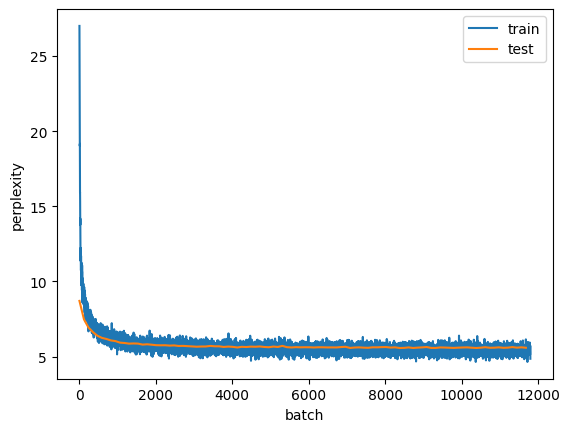

In [1138]:
#| code-summary: Train the model
opt = optim.SGD(m.parameters(), lr = 1)

train_perplexities, test_perplexities = [], []
for _ in range(100):

    for X, Y in train_loader:

        opt.zero_grad()

        outputs = m(X)
        outputs = outputs[-1]
        targets = Y[:, -1]

        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(m.parameters(), 1) # Clip the gradient
        opt.step()
        
        train_perplexities.append(np.exp(loss.item()))
    test_perplexities.append(eval(m, test_loader))

plt.plot(train_perplexities, label = 'train')
plt.plot(list(range(0, len(train_perplexities), len(train_loader))),test_perplexities, label = 'test')
plt.legend(); plt.xlabel('batch'); plt.ylabel('perplexity')

I.e. we got comparable results using one-hot encoding and learnable embeddings did not seem to improve performance.

# 6
>Conduct an experiment to determine how well this language model trained on The Time Machine works on other books by H. G. Wells, e.g., The War of the Worlds.

In [1139]:
#| code-summary: Evaluate on other texts

def eval_on_other_text(m, url):
    text = requests.get(url).text
    text = re.sub('[^A-Za-z]+', ' ', text).lower()
    tokens = list(text)
    test_dataset = OffsetSequences([char_to_ix[t] for t in tokens[:10000]], num_steps)
    test_loader  = DataLoader(test_dataset,  batch_size = batch_size, shuffle = False, drop_last = True)
    return eval(m, test_loader)

perplexities = {
    'time machine': eval(m, test_loader),
    'the sleeper awakes': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/12163/pg12163.txt'),
    'the war of the worlds': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/36/pg36.txt'),
    'britling sees it through': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/14060/pg14060.txt'),
    'certain personal matters': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/17508/pg17508.txt'),
}

perplexities

{'time machine': 5.590489799933571,
 'the sleeper awakes': 7.463832230616033,
 'the war of the worlds': 6.850138662194433,
 'britling sees it through': 8.232215427642316,
 'certain personal matters': 7.385997756118561}

We get increased losses on texts by the same author, presumably (and hopefully) because of changes in the stories, plot lines, etc. What about texts from other authors?

# 7
>Conduct another experiment to evaluate the perplexity of this model on books written by other authors.

In [1140]:
other_perplexities = {
    'The Mysterious Affair (Agatha)': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/12163/pg12163.txt'),
    'Odessy (Homer)': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/1727/pg1727.txt'),
    'Candice (Voltaire)': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/19942/pg19942.txt'),
    'Don Quixote (Cervantes)': eval_on_other_text(m, 'https://gutenberg.org/cache/epub/2000/pg2000.txt'),
}
other_perplexities

{'The Mysterious Affair (Agatha)': 7.463832230616033,
 'Odessy (Homer)': 7.94175036576811,
 'Candice (Voltaire)': 8.60364584900993,
 'Don Quixote (Cervantes)': 28.923269995282546}

With the first 3 texts I tried at first, there wasn't that much of a jump in perplexities. Evaluating the model in the last text in Spanish served as a sanity check.

# 8

>Modify the prediction method so as to use sampling rather than picking the most likely next character.
>
>- What happens?
>- Bias the model towards more likely outputs, e.g., by sampling from $q(x_t | x_{t-1}, ~\dots~, x_1) \propto P(x_t | x_{t-1}, ~\dots~, x_1)^\alpha$ for $\alpha > 1 $

We can do so by multiplying the logits by $\alpha$ (inverse temperature) before applying softmax. Notice that as $\alpha \rightarrow 0$ we sample tokens uniformly at random, and as $\alpha \rightarrow +\infty$ we'll select the most probable token.

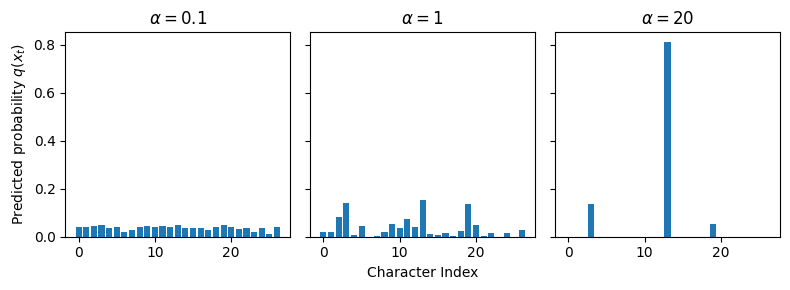

In [1142]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (8, 3), sharey = True)
with torch.no_grad():
    X, Y = next(iter(test_loader))
    logits = m(X)[-1][0]
    for ax, alpha in zip([ax1, ax2, ax3], [0.1, 1, 20]):
        probs = F.softmax(logits * alpha, dim = 0).numpy()
        ax.bar(list(range(len(vocab))), probs)
        ax.set_title(r'$\alpha = $' + str(alpha))

ax2.set_xlabel('Character Index'); ax1.set_ylabel(r'Predicted probability $q(x_{t})$'); f.tight_layout()

Let's observe qualitatively how generation is affected. We should expect to see less diverse but more probable sequences as we increase $\alpha$.

In [1144]:
@torch.no_grad()
def generate_by_sampling(model, preamble, num_chars, alpha, char_to_ix):

    generation = preamble
    prepare_X = lambda char: model.embed(torch.Tensor([[char_to_ix[char]]]).long())
    hidden_state = None

    for char in preamble: # warm-up
        hidden_state = model.rnn(prepare_X(char), hidden_state)[-1] # only the last hidden state

    for _ in range(num_chars): # generation
        hidden_state = model.rnn(prepare_X(generation[-1]), hidden_state)[-1]
        output = model.output_layer([hidden_state])
        weights = F.softmax(output.squeeze() * alpha, dim = 0)
        generation += ix_to_char[torch.multinomial(weights, 1).item()]

    return generation

for alpha in [0.1, 1, 2, 10]:
    print(f'alpha: {alpha}\tgeneration:{generate_by_sampling(m, "friday", 20, alpha, char_to_ix)}')

alpha: 0.1	generation:friday furzziis   ushxthfr
alpha: 1	generation:friday thought filltise to
alpha: 2	generation:friday to little the prese
alpha: 10	generation:friday the shate in the si


# 9
>Run the code in this section without clipping the gradient. What happens?

I was expecting exploding gradients and, thus, for the network to be untrainable, but surprisingly I did not observe it. I tried increasing the sequence length from 32 to 256,  adding hooks to debug, etc. Nothing.

/Users/emiliocantucervini/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


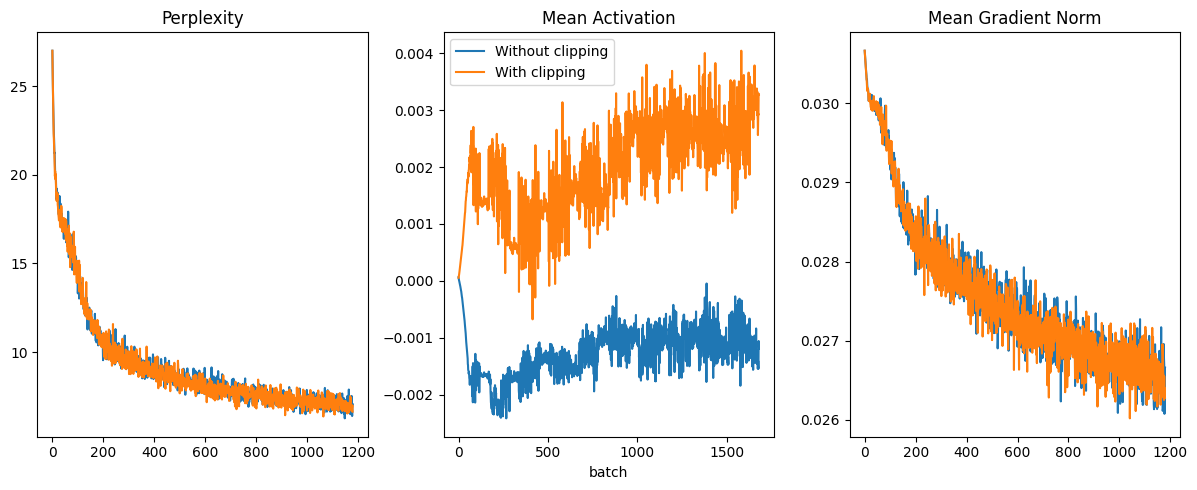

In [1146]:
#| code-summary: Train with and without graddient clipping

act_means, grad_norms = [], []
def log_activations(module, input, output): act_means.append(output[-1].mean().item())
def log_grad_norms(module, grad_input, grad_output): grad_norms.append(np.linalg.norm(grad_output[0]))

def nine(clipping):

    global act_means, grad_norms
    act_means, grad_norms = [], []

    batch_size, num_steps = 1024, 256
    train_dataset = OffsetSequences([char_to_ix[t] for t in tokens[:train_cutoff]], num_steps)
    test_dataset  = OffsetSequences([char_to_ix[t] for t in tokens[train_cutoff:]], num_steps)
    train_loader  = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, drop_last = True)
    test_loader   = DataLoader(test_dataset,  batch_size = batch_size, shuffle = False, drop_last = True)

    m = RNNLM(vocab_size = len(vocab), num_hiddens = 32)
    opt = optim.SGD(m.parameters(), lr = 1)

    hooks = [m.register_forward_hook(log_activations), m.register_backward_hook(log_grad_norms)]

    train_perplexities, test_perplexities = [], []
    for _ in range(10):

        for X, Y in train_loader:

            opt.zero_grad()

            outputs = m(X)
            outputs = outputs[-1]
            targets = Y[:, -1]

            loss = F.cross_entropy(outputs, targets)
            loss.backward()
            if clipping: nn.utils.clip_grad_norm_(m.parameters(), 1)
            opt.step()
            
            train_perplexities.append(np.exp(loss.item()))

        test_perplexities.append(eval(m, test_loader))

    for hook in hooks: hook.remove()

    return train_perplexities, test_perplexities

f, axs = plt.subplots(1, 3, figsize = (12, 5))

for clipping in [False, True]:

    train_perplexities, _ = nine(clipping = clipping)
    axs[0].plot(train_perplexities)
    #axs[0].plot(list(range(0, len(train_perplexities), len(train_loader))), test_perplexities, label = 'test')
    axs[0].set_title('Perplexity')#; axs[0].set_yscale('log')
    axs[1].plot(act_means, label = f'With{"out" if not clipping else ""} clipping'); axs[1].set_title('Mean Activation')
    axs[2].plot(grad_norms); axs[2].set_title('Mean Gradient Norm')

axs[1].set_xlabel('batch'); axs[1].legend()
f.tight_layout()

In [3]:
#| code-summary: RNN Language Model
#| code-fold: show

class RNNLM(nn.Module):
    def __init__(self, vocab_size, num_hiddens):
        super().__init__()
        self.vocab_size = vocab_size

        self.rnn = nn.RNN(vocab_size, num_hiddens)
        self.linear = nn.Linear(num_hiddens, vocab_size)
        
    def embed(self, X): return F.one_hot(X.T, self.vocab_size).type(torch.float32)
    
    def output_layer(self, hidden_states):
        return torch.stack([self.linear(H) for H in hidden_states])
        # return torch.stack([torch.matmul(H, self.W_hq) + self.b_q for H in hidden_states])
    def forward(self, X, H = None):
        return self.rnn(self.embed(X), H)
    
    @torch.no_grad()
    def generate(self, preamble, num_chars, char_to_ix):
    
        generation = preamble
        prepare_X = lambda char: self.embed(torch.Tensor([[char_to_ix[char]]]).long())
        hidden_state = None

        for char in preamble: # warm-up
            hidden_state = self.rnn(prepare_X(char), hidden_state)[-1] # only the last hidden state

        for _ in range(num_chars): # generation
            hidden_state = self.rnn(prepare_X(generation[-1]), hidden_state)[-1]
            output = self.output_layer([hidden_state])
            generation += ix_to_char[output.argmax(dim = 2).item()]

        return generation